In [1]:
import re
import tarfile
import os
import matplotlib.pyplot as plt
import numpy as np
import regex
import pandas as pd
import morfeusz2


%matplotlib inline

In [2]:
merged_law = open("merged_law.txt", "w+b")

tar = tarfile.open("ustawy.tar.gz", "r:gz")
for member in tar.getmembers():
    f = tar.extractfile(member)
    if f is not None:
        content = f.read()
        merged_law.write(content)
merged_law.close()

## 1
### addition of a unit (e.g. dodaje się ust. 5a),

https://regex101.com/r/frAaay/2

In [3]:
def get_addition_number(filename):
    file = open(filename, "r")
    text = file.read()
    expression = r"(((w)|(po))\s((art\.)|(ust\.)|(pkt)|rozdziale|§)\s\d+\w+\s?)*dodaje\ssię\s(now[y|e]\s)?(((w\s)?ust\.)|(art\.)|(poz\.)|(rozdział)|§|pkt|lit\.).*(w\s)?brzmieniu"
    pattern = regex.compile(expression, re.I)

    # for match in regex.finditer(pattern,text):
    #     print(match)
    return len([*regex.finditer(pattern, text)])


print(get_addition_number("merged_law.txt"))

5726


### removal of a unit (e.g. w art. 10 ust. 1 pkt 8 skreśla się)
https://regex101.com/r/aahqHw/6

In [4]:
def get_removal_number(filename):
    file = open(filename, "r")
    text = file.read()
    expression = r"(((skreśla)|uchyla)\ssię\s(((w\s)?ust\.)|(art\.)|(poz\.)|(rozdział)|§|pkt|lit\.|(dział)))|(((art\.?)|(ust\.?)|\§|(pkt\.?))\s\w+\s((skreśla)|(uchyla))\ssię(?!\s(wyrazy?|zdanie)))"
    pattern = regex.compile(expression, re.I)
    return len([*regex.finditer(pattern, text)])

print(get_removal_number("merged_law.txt"))

2156


### change of a unit (e.g. art. 5 otrzymuje brzmienie)
https://regex101.com/r/CWUPxg/2


In [5]:
def get_changes_number(filename):
    file = open(filename, "r")
    text = file.read()
    # firstly I thought about r"(otrzymuj[eą]\s((brzmienie)|(oznaczeni[ae])))|(oznacza\ssię)"
    # but it matched "w ust. 2 zdanie pierwsze otrzymuje brzmienie" So I prevented this behavior

    expression = r"(((w\s)?ust\.?)|(Kategoria)|(art\.?)|(poz\.?)|(rozdział)|§|pkt|lit\.?)(?!.*zdanie.*).*(otrzymuj[eą]\s((brzmienie)|(oznaczeni[ae])))|(oznacza\ssię)"
    pattern = regex.compile(expression, re.I)
    return len([*regex.finditer(pattern, text)])


print(get_changes_number("merged_law.txt"))

9289


In [6]:
units_added_yearly = []
units_changed_yearly = []
units_removed_yearly = []

path = "./ustawy"
paths = os.listdir(path)
for year in range(1993, 2005):
    filenames = list(filter(lambda x: x.startswith(str(year)), paths))
    units_added = 0
    units_changed = 0
    units_removed = 0
    for filename in filenames:
        units_added += get_addition_number(path + "/" + filename)
        units_changed += get_changes_number(path + "/" + filename)
        units_removed += get_removal_number(path + "/" + filename)
    units_added_yearly.append(units_added)
    units_changed_yearly.append(units_changed)
    units_removed_yearly.append(units_removed)

In [7]:
units_added_yearly

[29, 96, 324, 479, 615, 212, 158, 731, 1056, 89, 956, 981]

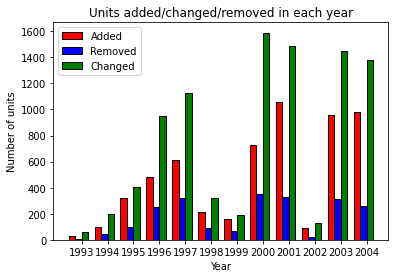

In [8]:
years = range(1993, 2005)
map(lambda x: str(x), years)

r = np.arange(len(years))
width = 0.25


plt.bar(
    r - width,
    units_added_yearly,
    color="r",
    width=width,
    edgecolor="black",
    label="Added",
)
plt.bar(
    r, units_removed_yearly, color="b", width=width, edgecolor="black", label="Removed"
)
plt.bar(
    r + width,
    units_changed_yearly,
    color="g",
    width=width,
    edgecolor="black",
    label="Changed",
)

plt.xlabel("Year")
plt.ylabel("Number of units")
plt.title("Units added/changed/removed in each year")

plt.xticks(r + width / 2, years)
plt.legend()

plt.show()

The same as above but show in % on y axis

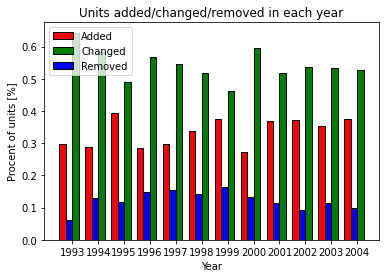

In [9]:

total = []
for i in range(len(years)):
    total.append(units_added_yearly[i]+units_changed_yearly[i]+units_removed_yearly[i]) 
    
perc_added = [a/t for a, t in zip(units_added_yearly,total)]
perc_changed = [a/t for a, t in zip(units_changed_yearly,total)]
perc_removed = [a/t for a, t in zip(units_removed_yearly,total)]


r = np.arange(len(years))
width = 0.25


plt.bar(r-width, perc_added, color = 'r',
        width = width, edgecolor = 'black',
        label='Added')
plt.bar(r + width, perc_changed, color = 'g',
        width = width, edgecolor = 'black',
        label='Changed')
plt.bar(r, perc_removed, color = 'b',
        width = width, edgecolor = 'black',
        label='Removed')
  
plt.xlabel("Year")
plt.ylabel("Procent of units [%]")
plt.title("Units added/changed/removed in each year")
  
plt.xticks(r + width/2,years)
plt.legend()
  
plt.show()

## 4, 5, 6
4. Compute the total number of occurrences of the word ustawa in any inflectional form (ustawa, ustawie, ustawę, etc.) and all spelling forms (ustawa, Ustawa, USTAWA), excluding other words with the same prefix (e.g. ustawić)

5. Compute the total number of occurrences of the same word (same conditions), followed by z dnia expression.

6. As above, but not followed by z dnia expression. Is the result correct (result 4 =? result 5 + result 6)?


In [10]:
file = open("merged_law.txt", "r")
# file = open("ustawy/1993_646.txt", "r")
text = file.read()

# test returning list with each match's line numbers
def test():
    matched_lines =[]
    for match in regex.finditer(pattern,text):
        lineno = text.count('\n', 0, match.start())
        matched_lines.append(lineno+1)
    return matched_lines

# test printing first "n" matched lines with line number
def test1(max_lines=50):
    matched_lines =[]
    i =0
    for match in regex.finditer(pattern,text):
        lineno = text.count('\n', 0, match.start())
        matched_lines.append(lineno+1)
        print(lineno+1,text.splitlines()[lineno])
        i+=1
        if i==max_lines:
            break

In [11]:
morf = morfeusz2.Morfeusz()
forms = morf.generate("ustawa")
forms = pd.DataFrame(forms)[0][:-1]  # -1 to remove last entry -> "U" which in my mind shouldn't be inflectional form


expression = '|'.join(forms)
expression = r'\b('+expression+r')\b'
print(expression)
pattern = regex.compile(expression, re.I)

# matched_lines=test()
law_total = len([*regex.finditer(pattern, text)])
print("total appearances of the word ustawa =",law_total)

\b(ustawa|ustawy|ustawie|ustawę|ustawą|ustawo|ustawy|ustaw|ustawom|ustawami|ustawach)\b
total appearances of the word ustawa = 24934


In [12]:
law_day =r"\b(ustawa|ustawy|ustawie|ustawę|ustawą|ustawo|ustawy|ustaw|ustawom|ustawami|ustawach)\b(?!\sz\sdnia)"

pattern = regex.compile(law_day, re.I)
law_day_amount = len([*regex.finditer(pattern, text)])

# matched_lines1 =test()

print(law_day_amount)

17418


In [13]:
law_without_day = r"\b(ustawa|ustawy|ustawie|ustawę|ustawą|ustawo|ustawy|ustaw|ustawom|ustawami|ustawach)\b(?=\sz\sdnia)"


pattern = regex.compile(law_without_day, re.I)
law_without_day_amount = len([*regex.finditer(pattern, text)])

# matched_lines2 =test()


print("law_day_amount+law_without_day_amount =", law_day_amount+law_without_day_amount)

law_day_amount+law_without_day_amount = 24934


In [14]:
# set(matched_lines) - set(matched_lines1 + matched_lines2) 

## 7, 8
7. Compute the total number of occurrences of the word ustawa in any inflectional form, excluding occurrences following o zmianie expression.
8. Plot results 4-7 using a bar chart

In [15]:
expression= r"(?<!(o\szmianie\s))\b(ustawa|ustawy|ustawie|ustawę|ustawą|ustawo|ustawy|ustaw|ustawom|ustawami|ustawach)\b"
pattern = regex.compile(expression, re.I)
number_of_occurrences = len([*regex.finditer(pattern, text)])
print(number_of_occurrences)

24082


In [16]:
test1()
    

6                                 USTAWA
14 W ustawie z dnia 8 stycznia 1993 r. o podatku od towarów i usług oraz o podatku
23              ustawy.";
56              ust. 1 pkt 1-5, 7-36 i 38, art. 15 oraz art. 20 ustawy z dnia 
362 25) w art. 47 wyrazy "w okresie 3 lat od dnia ogłoszenia ustawy" zastępuje się 
381          ustawy w życie" zastępuje się wyrazami "do 31 grudnia 1993 r.",
419              do ogłoszenia załączników do ustawy z uwzględnieniem
430    do niniejszej ustawy,
446 W okresie od dnia wejścia  w  życie  ustawy do 31 grudnia 1996 r. przepisu 
447 art. 34 ust. 2 w brzmieniu nadanym niniejszą ustawą nie stosuje się do wyrobów
450 Minister Finansów ogłosi w Dzienniku Ustaw Rzeczypospolitej Polskiej jednolity
451 tekst ustawy o podatku od towarów i usług oraz o podatku akcyzowym, z 
455 Ustawa wchodzi w życie z dniem 1 stycznia 1994 r.
457                                    Załączniki do ustawy 
1017                                 USTAWA
1020     o zmianie niektórych u

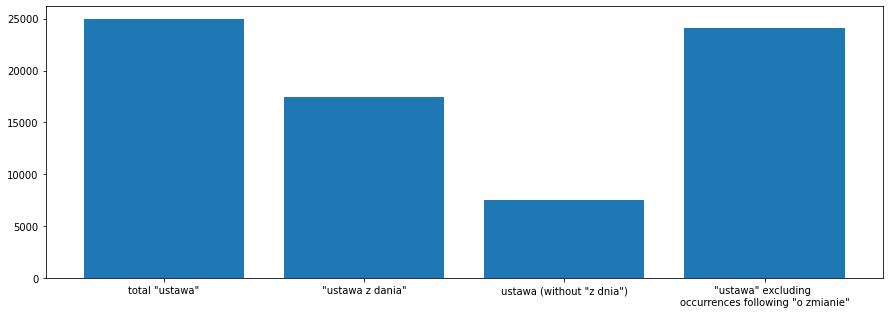

In [17]:
fig = plt.figure(figsize=(15,5))
langs = ['total "ustawa"', '"ustawa z dania"', 'ustawa (without "z dnia")', '"ustawa" excluding \noccurrences following "o zmianie"']
students = [law_total,law_day_amount,law_without_day_amount,number_of_occurrences]
plt.bar(langs,students)

plt.show()